In [1]:
# Install and import all relevant packages.

!pip install tensorflow
!pip install gdown

import tensorflow as tf
from tensorflow.python.client import device_lib
from google.colab import drive, files
import os
import zipfile
import gdown
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from PIL import Image
import matplotlib.gridspec as gridspec

In [2]:
# --- File and Folder Setup ---
zip_filename = "trainedWRc_resNet18_focalLoss.zip"
extract_folder = "trainedWRc_resNet18_focalLoss"

# --- IMPORTANT: Replace with your Google Drive shareable link ---
google_drive_url = "https://drive.google.com/file/d/10r--_yjxoG6uoqeAoi-T9Uck7982hqyx/view?usp=drive_link"

# 1️⃣ Check if zip file exists, otherwise download it from Google Drive
if not os.path.exists(zip_filename):
    print(f"Zip file '{zip_filename}' not found. Attempting to download from Google Drive...")
    try:
        # Extract the file ID from the URL. gdown can often handle the full URL,
        # but explicitly getting the ID is sometimes more robust.
        # A simple way to get the ID from a typical share link:
        # "https://drive.google.com/file/d/FILE_ID/view?usp=sharing"
        file_id = google_drive_url.split('/')[-2] # This assumes the common share link format
        print(f"Detected Google Drive File ID: {file_id}")

        # Download the file using gdown
        gdown.download(id=file_id, output=zip_filename, quiet=False)
        print(f"✅ Download of '{zip_filename}' complete.")
    except Exception as e:
        raise RuntimeError(f"❌ Failed to download '{zip_filename}' from Google Drive: {e}")
else:
    print(f"✅ Zip file '{zip_filename}' already exists. Skipping download.")

# 2️⃣ Check if the folder already exists, otherwise extract the zip file
if not os.path.exists(extract_folder):
    print(f"Extracting '{zip_filename}' into '{extract_folder}'...")
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall('.')
    print("✅ Extraction complete.")
else:
    print(f"✅ Folder '{extract_folder}' already exists. Skipping extraction.")

Zip file 'trainedWRc_resNet18_focalLoss.zip' not found. Attempting to download from Google Drive...
Detected Google Drive File ID: 10r--_yjxoG6uoqeAoi-T9Uck7982hqyx


Downloading...
From (original): https://drive.google.com/uc?id=10r--_yjxoG6uoqeAoi-T9Uck7982hqyx
From (redirected): https://drive.google.com/uc?id=10r--_yjxoG6uoqeAoi-T9Uck7982hqyx&confirm=t&uuid=43896329-6ac7-4b90-a7b8-3cc6d0c51571
To: /content/trainedWRc_resNet18_focalLoss.zip
100%|██████████| 41.6M/41.6M [00:00<00:00, 73.6MB/s]


✅ Download of 'trainedWRc_resNet18_focalLoss.zip' complete.
Extracting 'trainedWRc_resNet18_focalLoss.zip' into 'trainedWRc_resNet18_focalLoss'...
✅ Extraction complete.


In [3]:
# --- Load and summarize the model (existing code) ---
import trainedWRc_resNet18_focalLoss
model = trainedWRc_resNet18_focalLoss.load_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data_unnormalized   │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_               │ (None, 224, 224,  │    301,057 │ data_unnormalize… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ data_[0][0]       │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_ (Conv2D)     │ (None, 112, 112,  │      9,472 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv1_           │ (None, 112, 112,  │        256 │ conv1_[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ bn_conv1_[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ re_lu[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 58, 58,    │          0 │ max_pooling2d[0]… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2a_     │ (None, 56, 56,    │     36,928 │ zero_padding2d_2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2a_      │ (None, 56, 56,    │        256 │ res2a_branch2a_[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ bn2a_branch2a_[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 58, 58,    │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2b_     │ (None, 56, 56,    │     36,928 │ zero_padding2d_3… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2b_      │ (None, 56, 56,    │        256 │ res2a_branch2b_[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ bn2a_branch2b_[0… │
│                     │ 64)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ add[0][0]       

 Total params: 11,498,638 (43.86 MB)

 Trainable params: 11,187,981 (42.68 MB)

 Non-trainable params: 310,657 (1.19 MB)

In [4]:
# Dynamically extract image_size from the model's input shape
# model.input_shape typically returns (None, height, width, channels) for image inputs
image_size = (model.input_shape[1], model.input_shape[2])

# --- IMPORTANT: Replace with your Google Drive shareable link for the single image ---
# Make sure the link is set to "Anyone with the link" can view/download.
single_image_google_drive_url = "https://drive.google.com/file/d/1aMSF9p2_pnhj3RzWDuxU4uFyW8KhiwFs/view?usp=drive_link"

# Define the local path where the image will be saved
image_filename = "single_test_image.jpg" # You can change the name and extension as needed

# 1️⃣ Download the single image from Google Drive
# Extract the file ID from the URL.
file_id = single_image_google_drive_url.split('/')[-2]

# Download the file using gdown
gdown.download(id=file_id, output=image_filename, quiet=False)

true_class_name = 'Deposit' # <--- SET YOUR TRUE CLASS HERE, e.g., 'Broken'

# Load the original image without resizing for display
original_img = Image.open(image_filename) # Changed to Image.open()

# Calculate new dimensions to fit within image_size while preserving aspect ratio
original_width, original_height = original_img.size
target_width, target_height = image_size

# Determine scaling factor
scale = min(target_width / original_width, target_height / original_height)
new_width = int(original_width * scale)
new_height = int(original_height * scale)

# Resize the image
resized_img = original_img.resize((new_width, new_height), Image.LANCZOS) # Changed to Image.LANCZOS

# Create a new black image (canvas) of target_size
padded_img = Image.new("RGB", image_size, (0, 0, 0)) # Changed to Image.new()

# Calculate paste position to center the resized image
paste_x = (target_width - new_width) // 2
paste_y = (target_height - new_height) // 2

# Paste the resized image onto the black canvas
padded_img.paste(resized_img, (paste_x, paste_y))

# Assign the padded image to 'img' for consistency with previous code
img = padded_img

# Convert the padded PIL image to a numpy array
# By default, image.img_to_array converts to float32 with values in [0, 255]
img_array = image.img_to_array(img)
# Expand dimensions to create a batch of 1 image (required for model.predict)
img_array = np.expand_dims(img_array, axis=0)

Downloading...
From: https://drive.google.com/uc?id=1aMSF9p2_pnhj3RzWDuxU4uFyW8KhiwFs
To: /content/single_test_image.jpg
100%|██████████| 240k/240k [00:00<00:00, 79.0MB/s]


In [5]:
# 3️⃣ Make the prediction
y_pred_logits = model.predict(img_array)

# Convert logits to predicted class index
predicted_class_index = tf.argmax(y_pred_logits, axis=1).numpy()[0]

# Define the class names
class_names = ['Broken', 'Connection', 'Crack', 'Defective Connection', 'Deformed', 'Deposit', 'Displaced Joint', 'Fracture', 'Hole', 'Junction', 'Line of Sewer', 'Roots', 'Water']

# Get the predicted class name
predicted_class_name = class_names[predicted_class_index]

print(f"\n--- Prediction Result ---")
print(f"Predicted class index: {predicted_class_index}")
print(f"Predicted class name: {predicted_class_name}")
print(f"Raw prediction logits: {y_pred_logits}")
print(f"True class name: {true_class_name}")

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['data_unnormalized']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

--- Prediction Result ---
Predicted class index: 5
Predicted class name: Deposit
Raw prediction logits: [[5.9356491e-05 1.0065398e-02 3.0307327e-03 2.4403697e-04 1.1697065e-03
  7.5617886e-01 1.5452551e-03 1.2033075e-03 1.4742641e-03 3.6388740e-02
  3.1249486e-03 1.8089817e-01 4.6172077e-03]]
True class name: Deposit


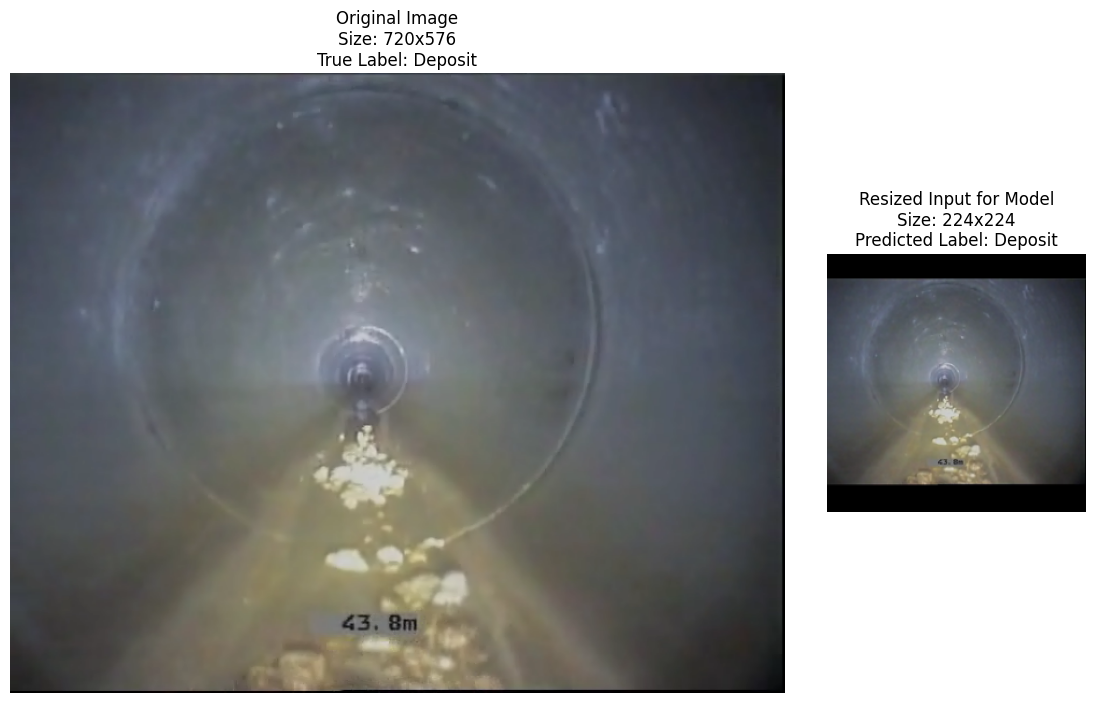

In [6]:
# 4️⃣ Display the original and processed images with labels

# Calculate total width and max height for dynamic figure sizing
# Assuming a DPI of 100 for conversion from pixels to inches for figsize
dpi = 100
total_width_px = original_img.size[0] + image_size[0] # Sum of widths of both images
max_height_px = max(original_img.size[1], image_size[1]) # Max height of either image

# Add some padding/margin to the figure size for better visual spacing
padding_factor = 1.2 # Adjust this factor as needed for more or less space
fig_width_inches = (total_width_px / dpi) * padding_factor
fig_height_inches = (max_height_px / dpi) * padding_factor

# Create a figure with dynamic size
fig = plt.figure(figsize=(fig_width_inches, fig_height_inches))

# Use GridSpec to define subplot ratios based on image widths
gs = gridspec.GridSpec(1, 2, width_ratios=[original_img.size[0], image_size[0]])

# Plot Original Image
ax0 = fig.add_subplot(gs[0]) # Use add_subplot with gridspec
ax0.imshow(original_img)
ax0.set_title(f"Original Image\nSize: {original_img.size[0]}x{original_img.size[1]}\nTrue Label: {true_class_name}")
ax0.axis('off')

# Plot Resized/Padded Image
ax1 = fig.add_subplot(gs[1]) # Use add_subplot with gridspec
ax1.imshow(img) # This is the padded image
ax1.set_title(f"Resized Input for Model\nSize: {image_size[0]}x{image_size[1]}\nPredicted Label: {predicted_class_name}")
ax1.axis('off')

plt.tight_layout() # Adjust layout to prevent titles from overlapping
plt.show()